In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lpt-1-dataset/LPT 1.xlsx
/kaggle/input/dpt1-dataset/DPT1.xlsx
/kaggle/input/lct2-dataset/LCT2.xlsx
/kaggle/input/lpt-2-dataset/LPT 2.xlsx
/kaggle/input/lct1-dataset/LCT1.xlsx


In [2]:
!pip install mpl-chord-diagram
!pip install eli5

  Preparing metadata (setup.py) ... done
  Created wheel for mpl-chord-diagram: filename=mpl_chord_diagram-0.4.1-py2.py3-none-any.whl size=16686 sha256=82bdfb829153788c62f5cac53886d75f49c33802e549330eafd11ef12b8ee4e9
  Stored in directory: /root/.cache/pip/wheels/e3/63/c5/7c88ede73f3c7d4921eeb8f1d620a7c7311992c4a452442334
Successfully built mpl-chord-diagram


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import eli5
from mpl_chord_diagram import chord_diagram
import re

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
2024-04-01 07:22:26.196785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 07:22:26.196903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 07:22:26.470366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
np.random.seed(45)

In [5]:
df = pd.read_excel("/kaggle/input/lct2-dataset/LCT2.xlsx")

In [6]:
df.head()

,PATIENT,DOSE,LOC,MORPHOLO+B1:BO1GICAL_Volume(IBSI:RNU0)[mm3],MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3],MORPHOLOGICAL_voxelsCounting(IBSI:No)[#vx],MORPHOLOGICAL_SurfaceArea(IBSI:C0JK)[mm2],MORPHOLOGICAL_SurfaceToVolumeRatio(IBSI:2PR5)[mm],MORPHOLOGICAL_Compacity(IBSI:No)[],MORPHOLOGICAL_Compactness1(IBSI:SKGS)[],...,GLSZM_LargeZoneLowGreyLevelEmphasis(IBSI:YH51),GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V),GLSZM_GreyLevelNonUniformity(IBSI:JNSA),GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO),GLSZM_ZoneSizeNonUniformity(IBSI:4JP3),GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A),GLSZM_ZonePercentage(IBSI:P30P),GLSZM_GreyLevelVariance(IBSI:BYLV),GLSZM_ZoneSizeVariance(IBSI:3NSA),GLSZM_ZoneSizeEntropy(IBSI:GU8N)
0,PT26.nii,0.826907,2,2665.125,2889,107,1309.309589,0.491275,17.776487,0.031738,...,0.000366,9892.853933,2.280899,0.025628,68.932584,0.774523,0.831776,190.553718,0.341119,5.762140
1,PT21.nii,1.576662,1,22626.000,23409,867,7343.720646,0.324570,27.814191,0.020284,...,0.000108,53235.946650,11.283537,0.017201,425.067073,0.647968,0.756632,291.243789,0.590141,6.812755
2,PT21.nii,1.126818,1,19801.125,20223,749,4728.887660,0.238819,16.422854,0.034354,...,0.000120,72419.658490,9.773585,0.018441,326.018868,0.615130,0.707610,280.242866,0.895297,6.820516
3,PT21.nii,1.053983,1,13052.250,13365,495,3692.676780,0.282915,17.192006,0.032817,...,0.000115,63417.158330,6.455556,0.017932,222.338889,0.617608,0.727273,347.264167,0.762153,6.772058
4,PT21.nii,0.707359,1,222219.000,224262,8306,51126.189450,0.230071,52.021629,0.010845,...,0.000124,71466.158190,55.360845,0.008855,4222.982086,0.675461,0.752709,963.729269,0.935251,7.808700


In [7]:
df.shape

(27, 123)

In [8]:
df.dtypes

PATIENT                                              object
DOSE                                                float64
LOC                                                   int64
MORPHOLO+B1:BO1GICAL_Volume(IBSI:RNU0)[mm3]         float64
MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]       int64
                                                     ...   
GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)    float64
GLSZM_ZonePercentage(IBSI:P30P)                     float64
GLSZM_GreyLevelVariance(IBSI:BYLV)                  float64
GLSZM_ZoneSizeVariance(IBSI:3NSA)                   float64
GLSZM_ZoneSizeEntropy(IBSI:GU8N)                    float64
Length: 123, dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Columns: 123 entries, PATIENT to GLSZM_ZoneSizeEntropy(IBSI:GU8N)
dtypes: float64(106), int64(16), object(1)
memory usage: 26.1+ KB


In [10]:
df.isna().sum()

PATIENT                                             0
DOSE                                                0
LOC                                                 0
MORPHOLO+B1:BO1GICAL_Volume(IBSI:RNU0)[mm3]         0
MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]     0
                                                   ..
GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)    0
GLSZM_ZonePercentage(IBSI:P30P)                     0
GLSZM_GreyLevelVariance(IBSI:BYLV)                  0
GLSZM_ZoneSizeVariance(IBSI:3NSA)                   0
GLSZM_ZoneSizeEntropy(IBSI:GU8N)                    0
Length: 123, dtype: int64

In [11]:
df.drop("PATIENT", axis = 1, inplace=True)

In [12]:
df.columns

Index(['DOSE', 'LOC', 'MORPHOLO+B1:BO1GICAL_Volume(IBSI:RNU0)[mm3]',
       'MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]',
       'MORPHOLOGICAL_voxelsCounting(IBSI:No)[#vx]',
       'MORPHOLOGICAL_SurfaceArea(IBSI:C0JK)[mm2]',
       'MORPHOLOGICAL_SurfaceToVolumeRatio(IBSI:2PR5)[mm]',
       'MORPHOLOGICAL_Compacity(IBSI:No)[]',
       'MORPHOLOGICAL_Compactness1(IBSI:SKGS)[]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       ...
       'GLSZM_LargeZoneLowGreyLevelEmphasis(IBSI:YH51)',
       'GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)',
       'GLSZM_GreyLevelNonUniformity(IBSI:JNSA)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)',
       'GLSZM_ZonePercentage(IBSI:P30P)', 'GLSZM_GreyLevelVariance(IBSI:BYLV)',
       'GLSZM_ZoneSizeVariance(IBSI:3NSA)',
       'GLSZM_ZoneSizeEntropy(IBSI:GU8N)'],
      dtype='object', length=122)

<Axes: >

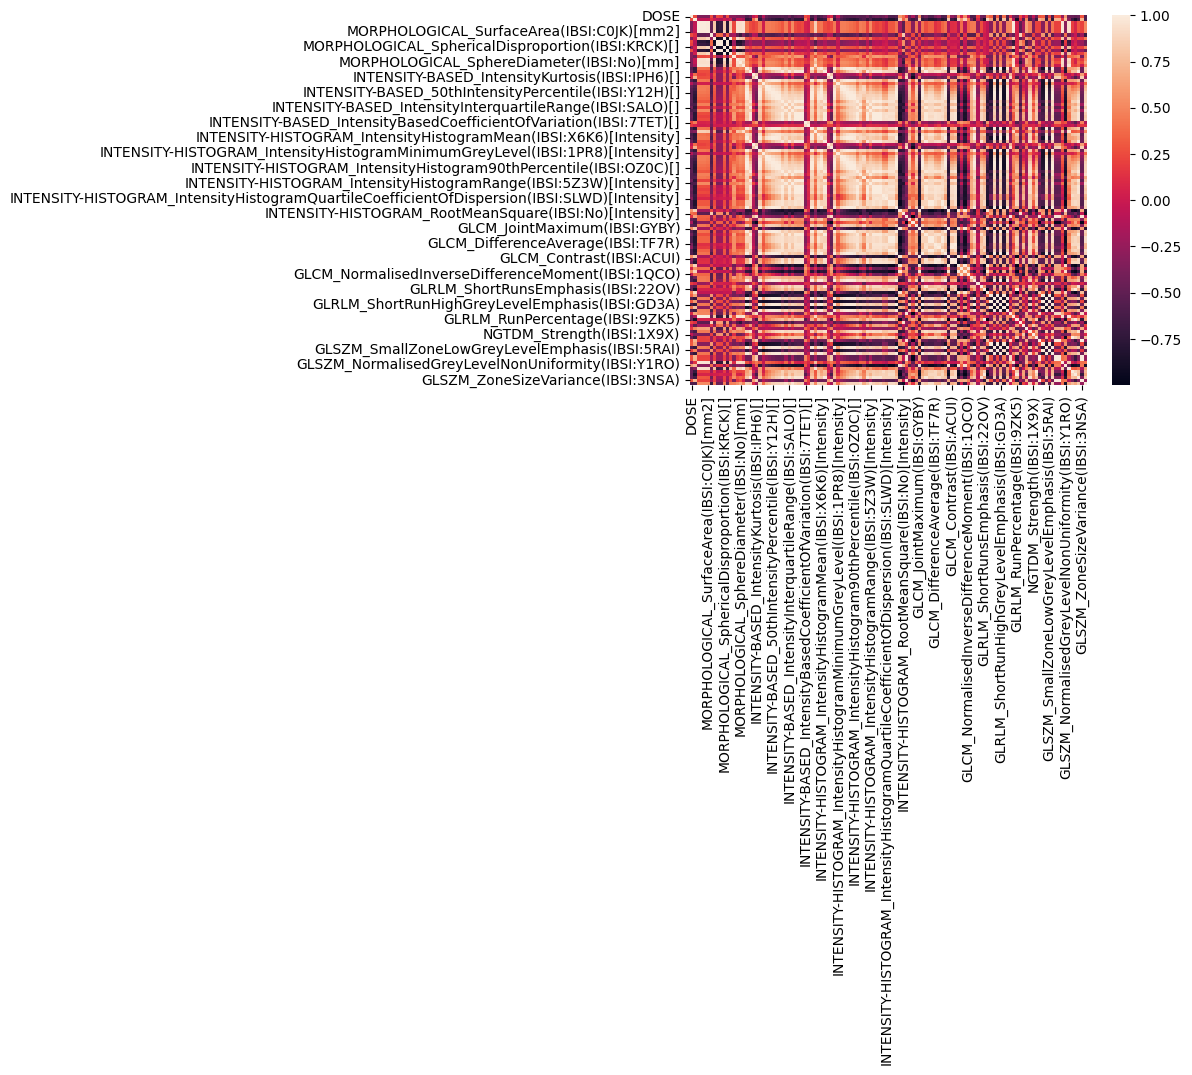

In [13]:
sns.heatmap(df.corr())

In [14]:
def calculate_scores(y, y_pred):
    # Calculate metrics
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    return r2, mae, mse

In [15]:
# Calculate and print mean scores for each metric
def print_scores(mode, r2_scores, mae_scores, mse_scores, rmse_scores):
    print("\nMean", mode, "Scores:")
    print("Mean R2 Score:", np.mean(r2_scores))
    print("Mean MAE:", np.mean(mae_scores))
    print("Mean MSE:", np.mean(mse_scores))
    print("Mean RMSE:", np.mean(rmse_scores))
    print()

In [16]:
# This function evaluates the performance of a model over multiple iterations
# using bootstrapping and KFold cross-validation with 5 splits.

def evaluate_model(X, y, model, n_iterations=500, sample_size=0.6, print_results=True):
    r2_train_scores = []
    mae_train_scores = []
    mse_train_scores = []
    rmse_train_scores = []

    r2_test_scores = []
    mae_test_scores = []
    mse_test_scores = []
    rmse_test_scores = []
    
    # K-fold cross-validation with k = 5
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for i in range(n_iterations):
        
        # Bootstrap resampling of the data
        X_boot, y_boot = resample(X, y, replace=True, n_samples=int(sample_size * len(X)), random_state=16)
        
        r2_train_fold_scores = []
        mae_train_fold_scores = []
        mse_train_fold_scores = []
        
        r2_test_fold_scores = []
        mae_test_fold_scores = []
        mse_test_fold_scores = []
        
        for fold, (train_index, test_index) in enumerate(kf.split(X_boot), 1):
            X_train, X_test = X_boot[train_index], X_boot[test_index]
            y_train, y_test = y_boot.iloc[train_index], y_boot.iloc[test_index]
            
            # Fit the model
            model.fit(X_train, y_train)
            
            # Predict
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Calculate metrics
            r2_train, mae_train, mse_train = calculate_scores(y_train, y_train_pred)
            
            r2_test, mae_test, mse_test = calculate_scores(y_test, y_test_pred)
            
            # Append scores for this fold
            r2_train_fold_scores.append(r2_train)
            mae_train_fold_scores.append(mae_train)
            mse_train_fold_scores.append(mse_train)
            
            r2_test_fold_scores.append(r2_test)
            mae_test_fold_scores.append(mae_test)
            mse_test_fold_scores.append(mse_test)
            

        # Append mean scores for this iteration
        r2_train_scores.append(np.mean(r2_train_fold_scores))
        mae_train_scores.append(np.mean(mae_train_fold_scores))
        mse_train_scores.append(np.mean(mse_train_fold_scores))
        rmse_train_scores.append(np.sqrt(np.mean(mse_train_fold_scores)))
        
        r2_test_scores.append(np.mean(r2_test_fold_scores))
        mae_test_scores.append(np.mean(mae_test_fold_scores))
        mse_test_scores.append(np.mean(mse_test_fold_scores))
        rmse_test_scores.append(np.sqrt(np.mean(mse_test_fold_scores)))

    if (print_results):
        # Train scores
        print_scores('Train', r2_train_scores, mae_train_scores, mse_train_scores, rmse_train_scores)
        
        # Test scores
        print_scores('Test', r2_test_scores, mae_test_scores, mse_test_scores, rmse_test_scores)
    
    return np.mean(r2_test_scores), np.mean(mse_test_scores)

In [17]:
def evaluate_based_on_feature_number(X_sorted, y, model):
    num_features_list = []
    r2_scores = []
    mse_scores = []

    # Iterate over different numbers of selected features
    for num_features in range(X_sorted.shape[1], 1, -1):
        # Select top num_features features
        X_selected = X_sorted[:, :num_features]
        
        # We set bootstrapping iterations to 10 for reducing complexity
        # since the plot is just for estimation and not final evaluation
        r2, mse = evaluate_model(X_selected, y, model, n_iterations=10, print_results=False)    
        
        num_features_list.append(num_features)
        r2_scores.append(r2)
        mse_scores.append(mse)

    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, r2_scores, marker='o', label='R^2 Score')
    plt.plot(num_features_list, mse_scores, marker='x', label='Mean Squared Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Score')
    plt.title('Model Performance vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:

def evaluate_based_on_feature_number2(X_sorted, y, model):
    num_features_list = []
    r2_scores = []
    mse_scores = []

    # Iterate over different numbers of selected features
    for num_features in range(X_sorted.shape[1], 1, -1):
        # Select top num_features features
        X_selected = X_sorted[:, :num_features]
        
        # We set bootstrapping iterations to 10 for reducing complexity
        # since the plot is just for estimation and not final evaluation
        r2, mse = evaluate_model(X_selected, y, model, n_iterations=10, print_results=False)    
        
        num_features_list.append(num_features)
        r2_scores.append(r2)
        mse_scores.append(mse)

    # Plot R^2 Score
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, r2_scores, marker='o', label='R^2 Score')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Score vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Mean Squared Error (MSE)
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, mse_scores, marker='x', label='Mean Squared Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
def one_hot_encoding(df, feature_name):
    if feature_name in df.columns:
        encoder = OneHotEncoder(sparse_output=False)
        encoded_data = encoder.fit_transform(df[[feature_name]])
        one_hot_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([feature_name]))
        df = pd.concat([df, one_hot_df], axis=1)
        df = df.drop(feature_name, axis=1)
    return df   

In [20]:
# For simpler visualization
def get_simple_feature_name(feature_names):
    simple_names = []
    for feature_name in feature_names:
        simple_name=feature_name
        pattern = r'\((.*)'
        match = re.search(pattern, feature_name)
        if match:
            simple_name = match.group(1)
            if simple_name in simple_names:
                last_underscore_index = feature_name.rfind('_')
                simple_name = feature_name[last_underscore_index:] if last_underscore_index != -1 else feature_name
        simple_names.append(simple_name)
    return simple_names

In [21]:
def hist_plot(df):
    df_renamed = df.copy()
    df_renamed.columns = get_simple_feature_name(df.columns)
    df_renamed.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [22]:
def pair_plot(X, y):
    X_renamed = X.copy()
    X_renamed.columns = get_simple_feature_name(X.columns)
    y_df = y.to_frame().rename(columns={0: 'Dose'})
    df = pd.concat([X_renamed, y_df], axis=1)
    for i in range(0, len(df.columns), 5):
        sns.pairplot(data=df,
                     x_vars=df.columns[i:i+5],
                     y_vars=['DOSE'])

In [23]:
def plot_chord_diagram(X):
    fig, ax = plt.subplots(figsize=(12, 12))
    chord_diagram(X.corr(), names=get_simple_feature_name(X.columns), ax=ax, rotation=0, fontsize=8)
    plt.show()

In [24]:
y=df['DOSE']
X=df.drop('DOSE', axis=1)

In [25]:
X_scaled = StandardScaler().fit_transform(X)

Section 1: Three-Step Feature Selection using Lasso Regression, Random Forest and Recursive Feature Elimination (RFE) 

Model: XGBRegressor trained using k fold cross-validation with bootstrapping

In [26]:
# Step 1: Initial feature selection using Lasso regression
# Eliminating features with lasso coef of 0
lasso = Lasso(alpha=0.05, max_iter=10000) 
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]
for f, feature in enumerate(selected_features):
    print("%d. Feature %s (%f)" % (f + 1, feature, lasso.coef_[f]))

1. Feature LOC (-0.810259)
2. Feature MORPHOLOGICAL_Compacity(IBSI:No)[] (-0.000000)
3. Feature MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[] (-0.000000)
4. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm] (-0.000000)
5. Feature INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[] (-0.000000)
6. Feature INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[] (-0.000000)
7. Feature INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity] (-0.208166)
8. Feature INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity] (-0.000000)
9. Feature GLCM_Contrast(IBSI:ACUI) (-0.237499)
10. Feature GLCM_Correlation(IBSI:NI2N) (-0.000000)
11. Feature GLCM_ClusterShade(IBSI:7NFM) (-0.000000)
12. Feature NGTDM_Coarseness(IBSI:QCDE) (-0.000000)
13. Feature NGTDM_Busyness(IBSI:NQ30) (-0.006750)
14. Feature GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO) (-0.000000)
15. Feature GLSZM_ZonePercentage(IBSI:P30P) (-0.000000)


In [27]:
eli5.show_weights(lasso, top=-1, feature_names = X.columns.tolist())

Weight?,Feature
+1.432,<BIAS>
+0.601,GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)
+0.320,GLCM_Contrast(IBSI:ACUI)
+0.067,NGTDM_Busyness(IBSI:NQ30)
-0.005,GLCM_ClusterShade(IBSI:7NFM)
-0.007,MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]
-0.034,INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[]
-0.053,INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]
-0.208,MORPHOLOGICAL_Compacity(IBSI:No)[]
-0.211,INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]


In [28]:
X_selected = X[selected_features]

In [29]:
X_selected.columns

Index(['LOC', 'MORPHOLOGICAL_Compacity(IBSI:No)[]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]',
       'GLCM_Contrast(IBSI:ACUI)', 'GLCM_Correlation(IBSI:NI2N)',
       'GLCM_ClusterShade(IBSI:7NFM)', 'NGTDM_Coarseness(IBSI:QCDE)',
       'NGTDM_Busyness(IBSI:NQ30)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLSZM_ZonePercentage(IBSI:P30P)'],
      dtype='object')

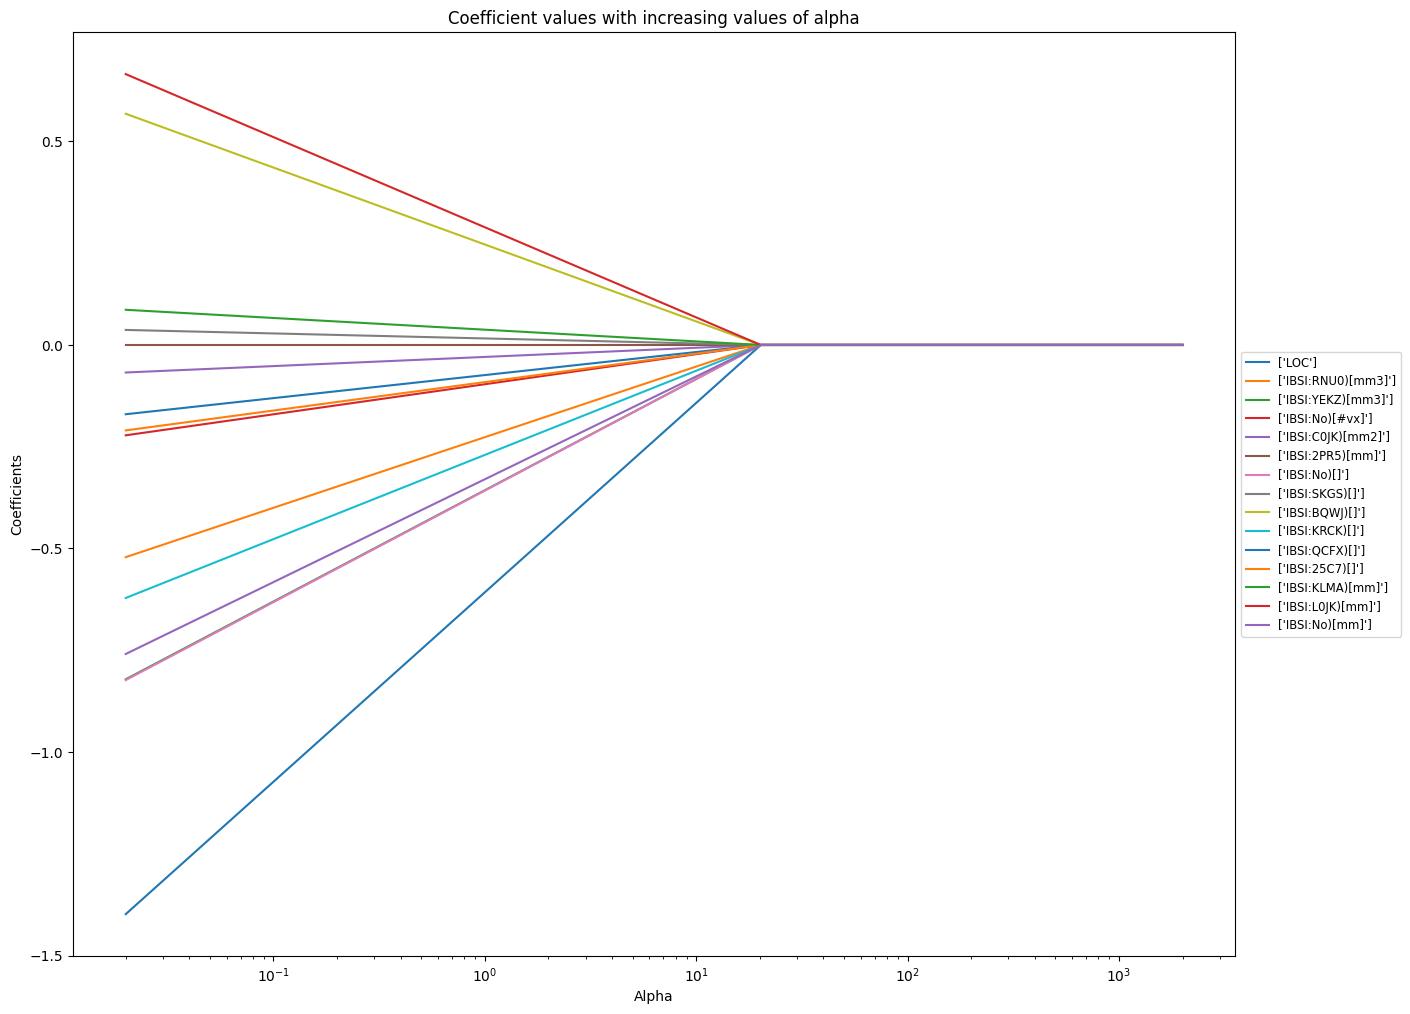

In [30]:
plt.figure(figsize=(15, 12))  

alphas = np.linspace(0.01, 1000, 100)
coefs = []

# Loop through each alpha value
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(StandardScaler().fit_transform(X_selected), y)
    coefs.append(lasso.coef_)

# Plot each feature's coefficient against alpha
ax = plt.gca()
for idx, feature_coef in enumerate(np.array(coefs).T):
    ax.plot(alphas*2, feature_coef, label=get_simple_feature_name([X.columns[idx]]))

ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
ax.grid(False)
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title("Coefficient values with increasing values of alpha")
plt.show()



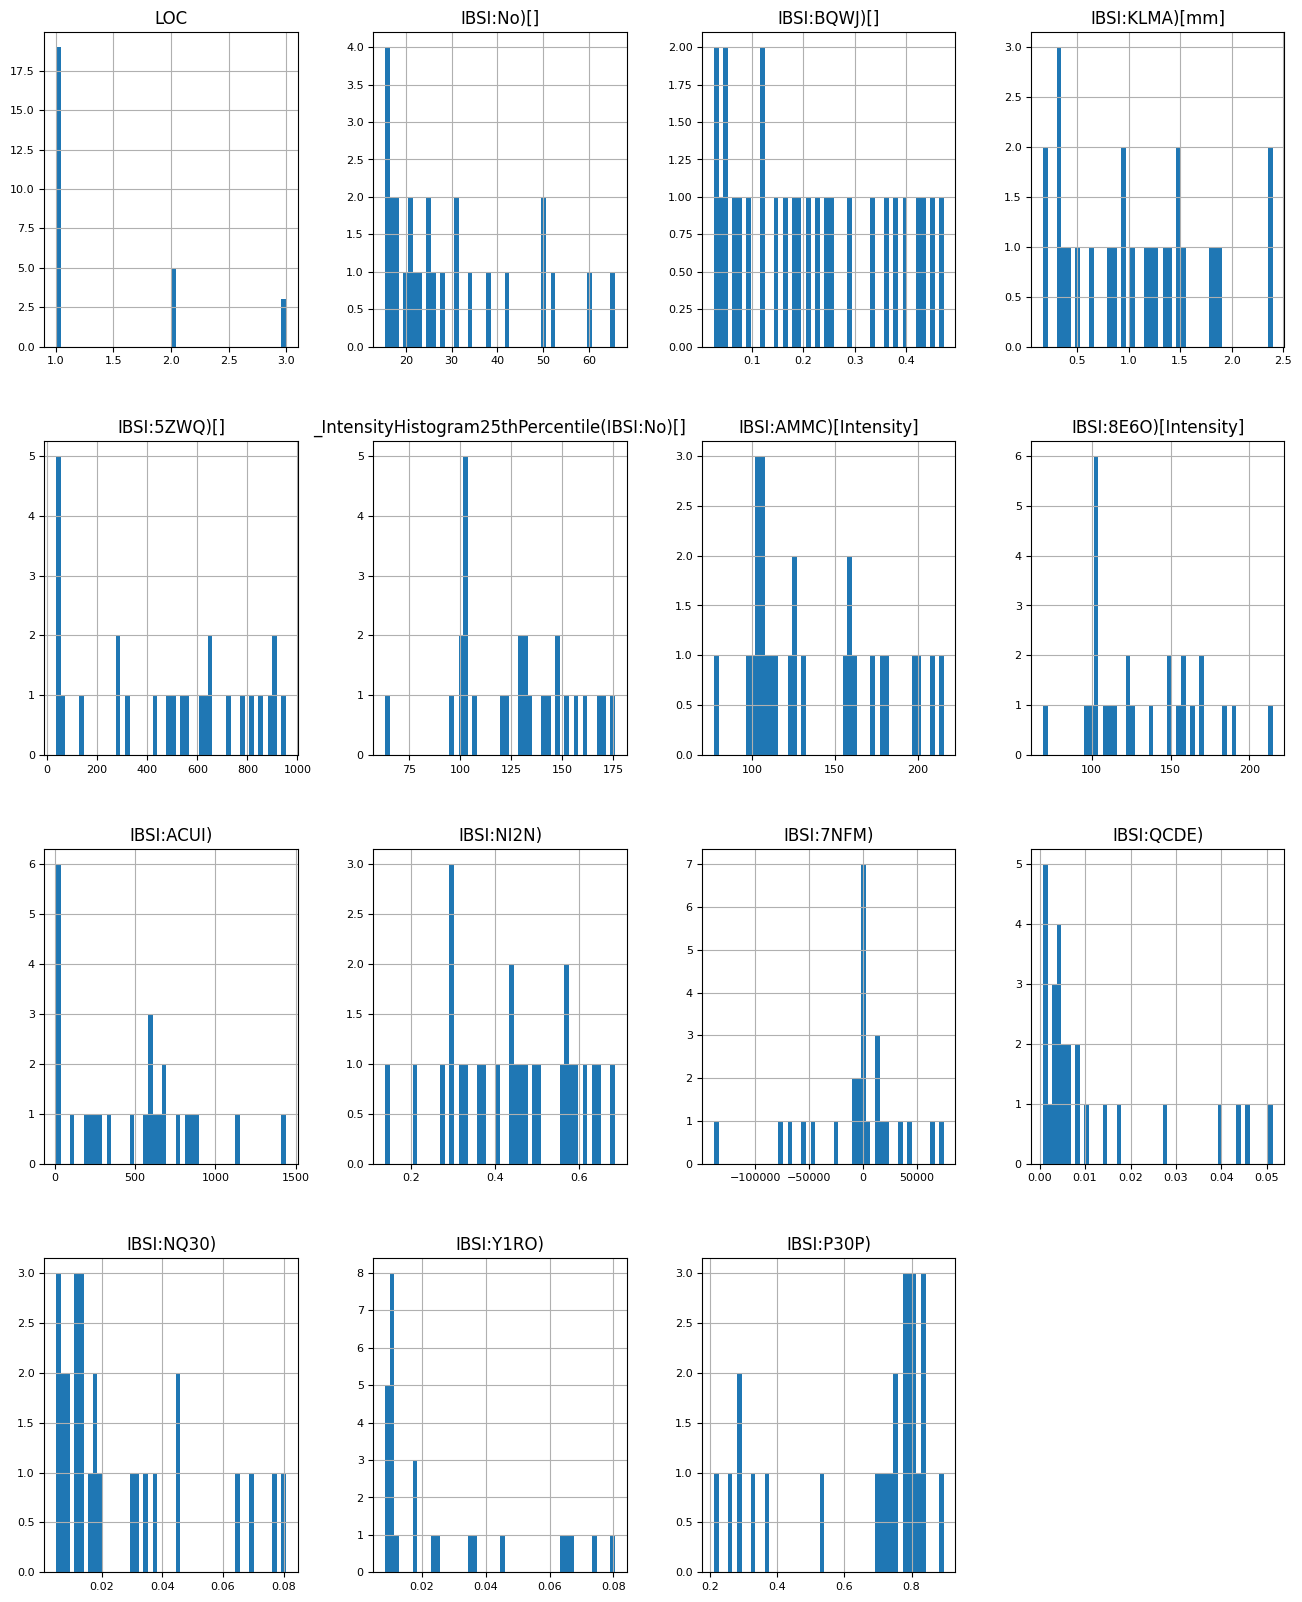

In [31]:
hist_plot(X_selected)

In [32]:
X_selected.dtypes

LOC                                                                              int64
MORPHOLOGICAL_Compacity(IBSI:No)[]                                             float64
MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]                                        float64
MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]                                 float64
INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]                           float64
INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[]                  int64
INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]                 int64
INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]      int64
GLCM_Contrast(IBSI:ACUI)                                                       float64
GLCM_Correlation(IBSI:NI2N)                                                    float64
GLCM_ClusterShade(IBSI:7NFM)                                                   float64
NGTDM_Coarseness(IBSI:QCDE)                

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


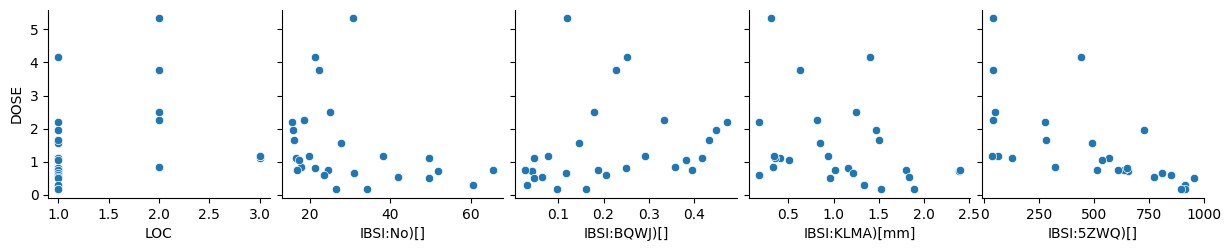

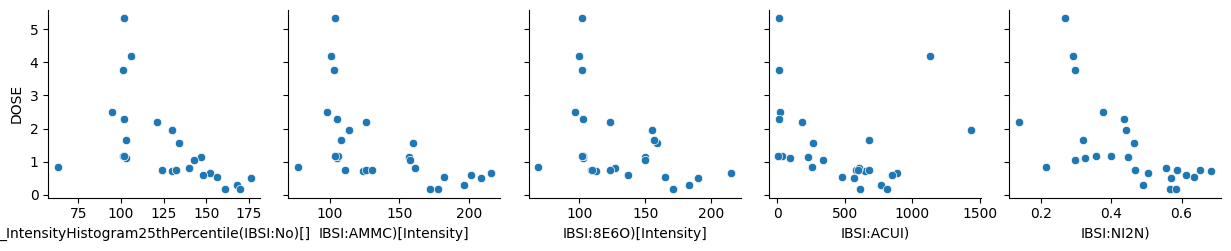

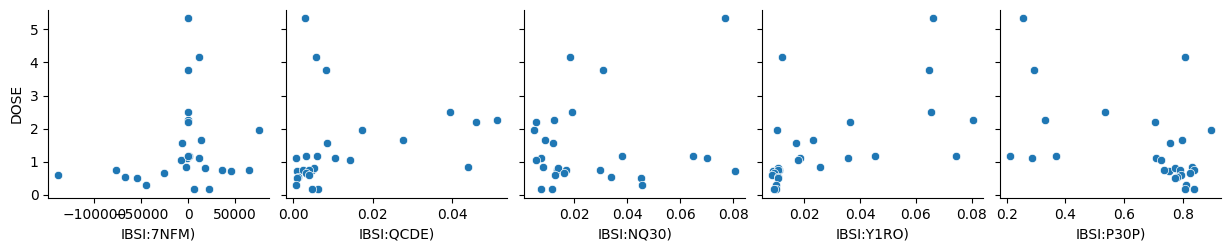

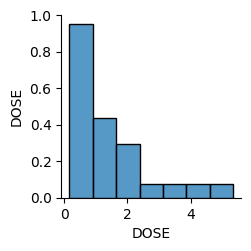

In [33]:
# Pair plots between the lasso selected features in X and the target variable DOSE.
pair_plot(X_selected, y)

In [34]:
# Encode LOC feature to one hot encoding
X_selected_encoded = one_hot_encoding(X_selected, 'LOC')

In [35]:
# Step 1 selected features
X_selected_encoded.columns

Index(['MORPHOLOGICAL_Compacity(IBSI:No)[]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]',
       'GLCM_Contrast(IBSI:ACUI)', 'GLCM_Correlation(IBSI:NI2N)',
       'GLCM_ClusterShade(IBSI:7NFM)', 'NGTDM_Coarseness(IBSI:QCDE)',
       'NGTDM_Busyness(IBSI:NQ30)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLSZM_ZonePercentage(IBSI:P30P)', 'LOC_1', 'LOC_2', 'LOC_3'],
      dtype='object')

In [36]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_encoded)

In [37]:
# Evaluate the GradientBoostingRegressor model perfonmance on lasso selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999981974084
Mean MAE: 5.204600895156793e-05
Mean MSE: 4.446126153014803e-09
Mean RMSE: 6.667927828804692e-05


Mean Test Scores:
Mean R2 Score: 0.9610580675485997
Mean MAE: 0.13276135414879084
Mean MSE: 0.06513090709616241
Mean RMSE: 0.25520757648659737



Text(0.5, 1.0, 'Feature Importance ')

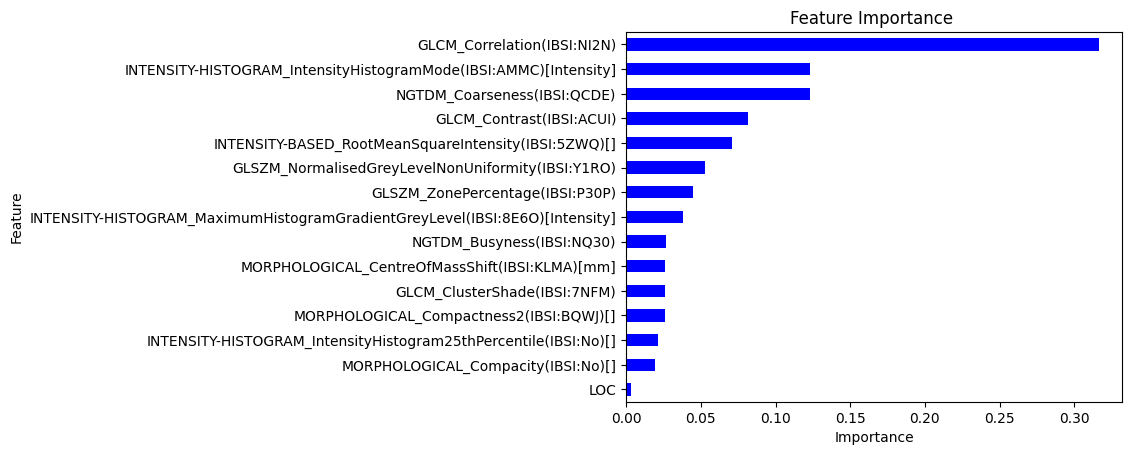

In [38]:
# Step 2: Train a Random Forest regressor with 100 decision trees 
# Select features from first step with rf feature importance > 0.02

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_selected, y)

importances_df = pd.Series(rf.feature_importances_, index=X_selected.columns)
importances_df.sort_values(ascending=True, inplace=True)
importances_df[:20].plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance ")

In [39]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_selected.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_selected.columns.values[indices[f]], 
          importances[indices[f]]))

1. Feature GLCM_Correlation(IBSI:NI2N) (0.316279)
2. Feature INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity] (0.123405)
3. Feature NGTDM_Coarseness(IBSI:QCDE) (0.122981)
4. Feature GLCM_Contrast(IBSI:ACUI) (0.081677)
5. Feature INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[] (0.070915)
6. Feature GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO) (0.053010)
7. Feature GLSZM_ZonePercentage(IBSI:P30P) (0.044987)
8. Feature INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity] (0.038286)
9. Feature NGTDM_Busyness(IBSI:NQ30) (0.026408)
10. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm] (0.026290)
11. Feature GLCM_ClusterShade(IBSI:7NFM) (0.026216)
12. Feature MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[] (0.026071)
13. Feature INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[] (0.021089)
14. Feature MORPHOLOGICAL_Compacity(IBSI:No)[] (0.019129)
15. Feature LOC (0.003257)


In [40]:
X_selected2 = X_selected.iloc[:, importances>0.02]

In [41]:
# Step 2 selected features
X_selected2.columns

Index(['MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]',
       'GLCM_Contrast(IBSI:ACUI)', 'GLCM_Correlation(IBSI:NI2N)',
       'GLCM_ClusterShade(IBSI:7NFM)', 'NGTDM_Coarseness(IBSI:QCDE)',
       'NGTDM_Busyness(IBSI:NQ30)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLSZM_ZonePercentage(IBSI:P30P)'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


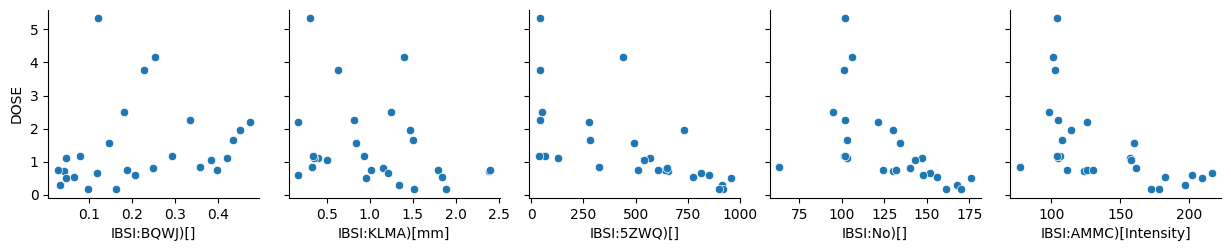

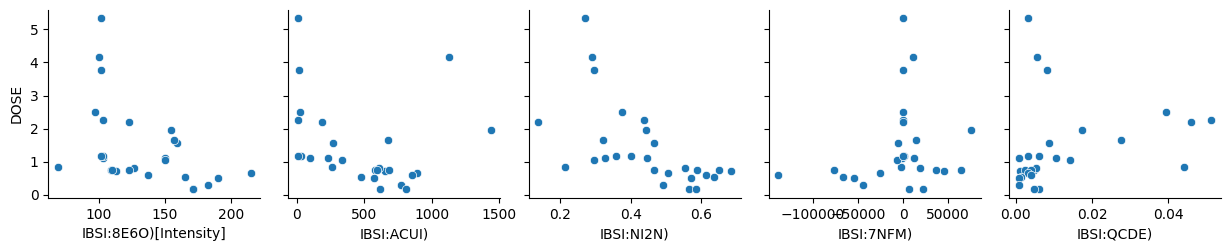

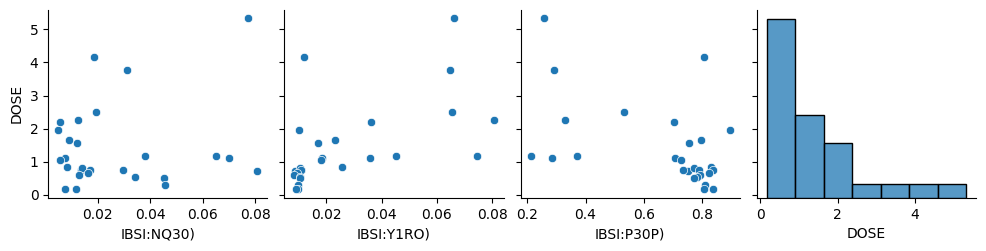

In [42]:
pair_plot(X_selected2, y)

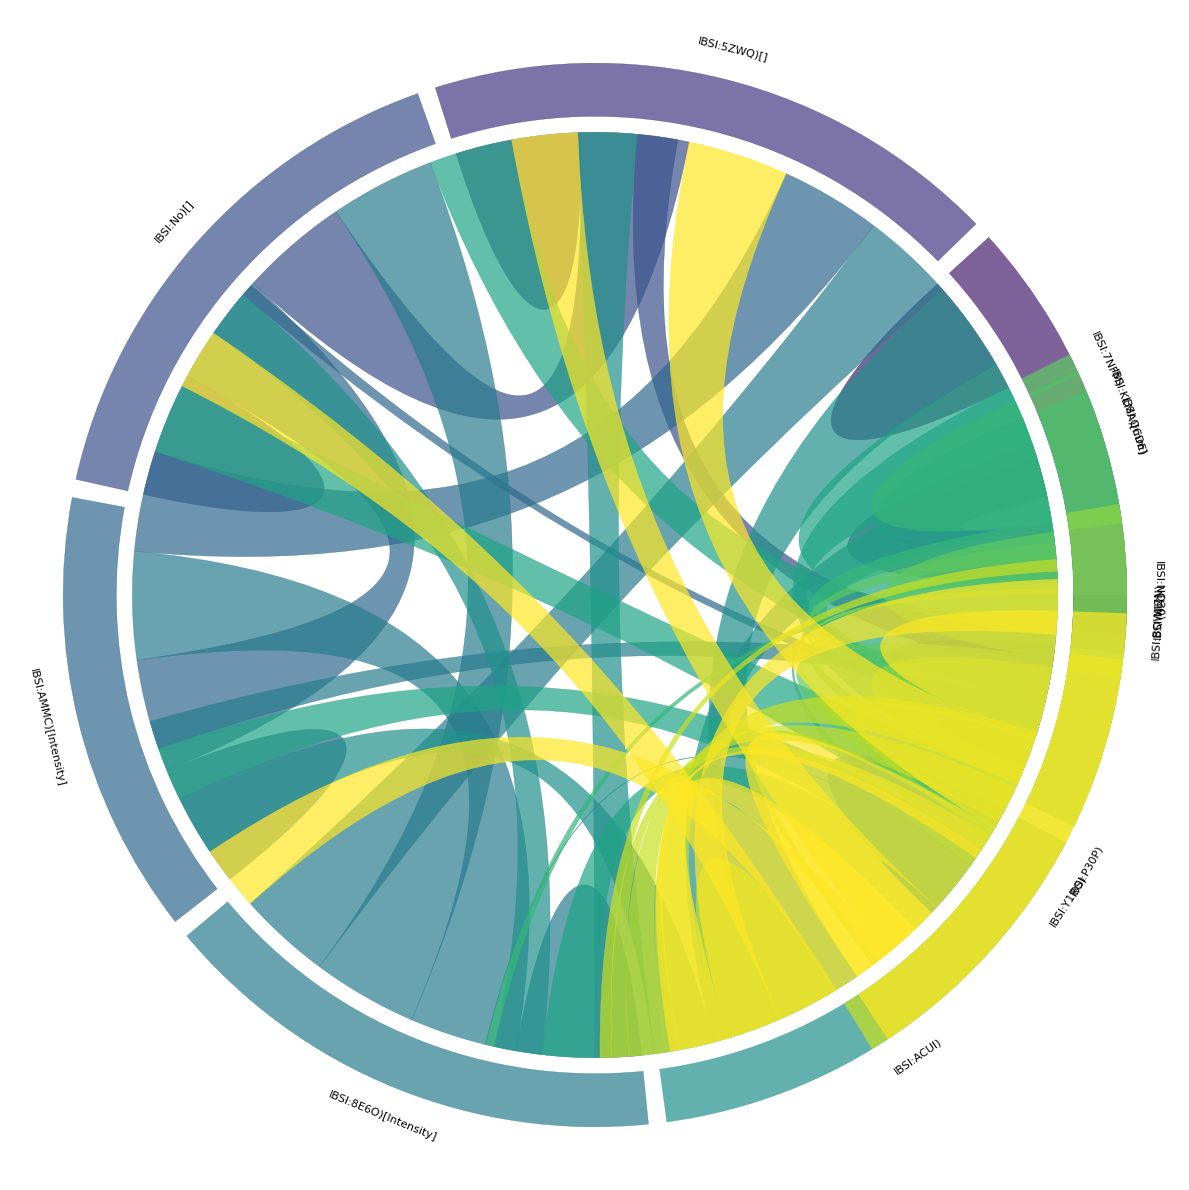

In [43]:
# Chord diagram for visualizing the correlation between selected features
plot_chord_diagram(X_selected2)

In [44]:
X_selected2_encoded = one_hot_encoding(X_selected2, 'LOC')

In [45]:
X_selected2_scaled = StandardScaler().fit_transform(X_selected2_encoded)

In [46]:
# Evaluate the GradientBoostingRegressor model perfonmance on random forest selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected2_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999981974084
Mean MAE: 5.204600895156793e-05
Mean MSE: 4.446126153014803e-09
Mean RMSE: 6.667927828804692e-05


Mean Test Scores:
Mean R2 Score: 0.9200724773805967
Mean MAE: 0.16371532302706823
Mean MSE: 0.0818992794951989
Mean RMSE: 0.286180501598552



In [47]:
# Step 3: Recursive Feature Elimination (RFE) Using XGBRegressor as the estimator
# Select 8 top features from step 2 selected features
estimator = XGBRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_selected2, y)  
selected_features = X_selected2.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))


1. Feature MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]
2. Feature INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]
3. Feature INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[]
4. Feature INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]
5. Feature GLCM_Contrast(IBSI:ACUI)
6. Feature GLCM_Correlation(IBSI:NI2N)
7. Feature GLCM_ClusterShade(IBSI:7NFM)
8. Feature NGTDM_Coarseness(IBSI:QCDE)


In [48]:
X_selected3 = X_selected2[selected_features]

In [49]:
X_selected3.shape

(27, 8)

In [50]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected3_sorted = X_selected2.iloc[:, sorted_selected_indices]

In [51]:
X_selected3_sorted.shape

(27, 8)

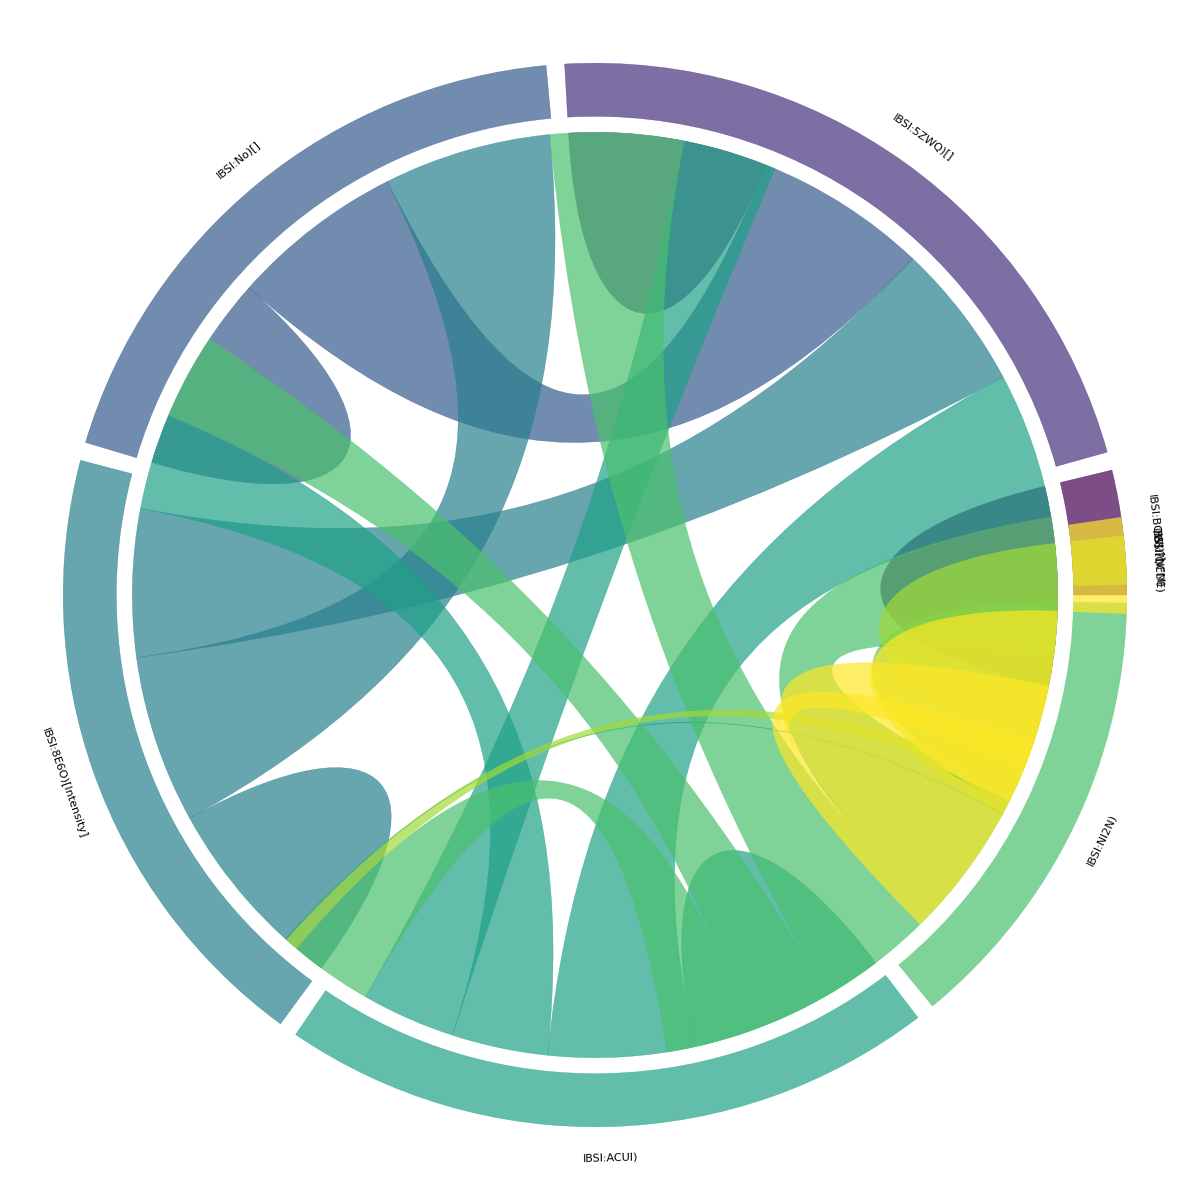

In [52]:
plot_chord_diagram(X_selected3)

In [53]:
# Final 8 selected features
X_selected3.columns

Index(['MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[]',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]',
       'GLCM_Contrast(IBSI:ACUI)', 'GLCM_Correlation(IBSI:NI2N)',
       'GLCM_ClusterShade(IBSI:7NFM)', 'NGTDM_Coarseness(IBSI:QCDE)'],
      dtype='object')

In [54]:
X_selected3_encoded = one_hot_encoding(X_selected3_sorted, 'LOC')

In [55]:
X_selected3_scaled = StandardScaler().fit_transform(X_selected3_encoded)

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
for train_index, test_index in kf.split(X_selected3, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 21, Test set:6
Fold:2, Train set: 21, Test set:6
Fold:3, Train set: 22, Test set:5
Fold:4, Train set: 22, Test set:5
Fold:5, Train set: 22, Test set:5


In [57]:
# Final evaluation after 3 step feature selection using GradientBoostingRegressor as a model
# On final 8 selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.999999996744012
Mean MAE: 6.945198196463136e-05
Mean MSE: 8.145659453267402e-09
Mean RMSE: 9.025330715972355e-05


Mean Test Scores:
Mean R2 Score: 0.7739361795777033
Mean MAE: 0.22762126156557827
Mean MSE: 0.17853464314430917
Mean RMSE: 0.42253360001816337



Section 2: One Step Feature Selection Using Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [60]:
# Recursive Feature Elimination (RFE) on the entire dataset
# Using XGBRegressor as the estimator and select 8 top features
estimator=XGBRegressor()
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_scaled, y)  
selected_features = X.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))

1. Feature MORPHOLOGICAL_SurfaceToVolumeRatio(IBSI:2PR5)[mm]
2. Feature MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]
3. Feature INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]
4. Feature INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]
5. Feature INTENSITY-BASED_MaximumIntensity(IBSI:84IY)[]
6. Feature INTENSITY-BASED_IntensityBasedQuartileCoefficientOfDispersion(IBSI:9S40)[]
7. Feature INTENSITY-BASED_IntensityBasedEnergy(IBSI:N8CA)[]
8. Feature NGTDM_Contrast(IBSI:65HE)


In [61]:
X_selected = X[selected_features]

In [62]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected_sorted = X.iloc[:, sorted_selected_indices]

In [63]:
X_selected_sorted.shape

(27, 8)

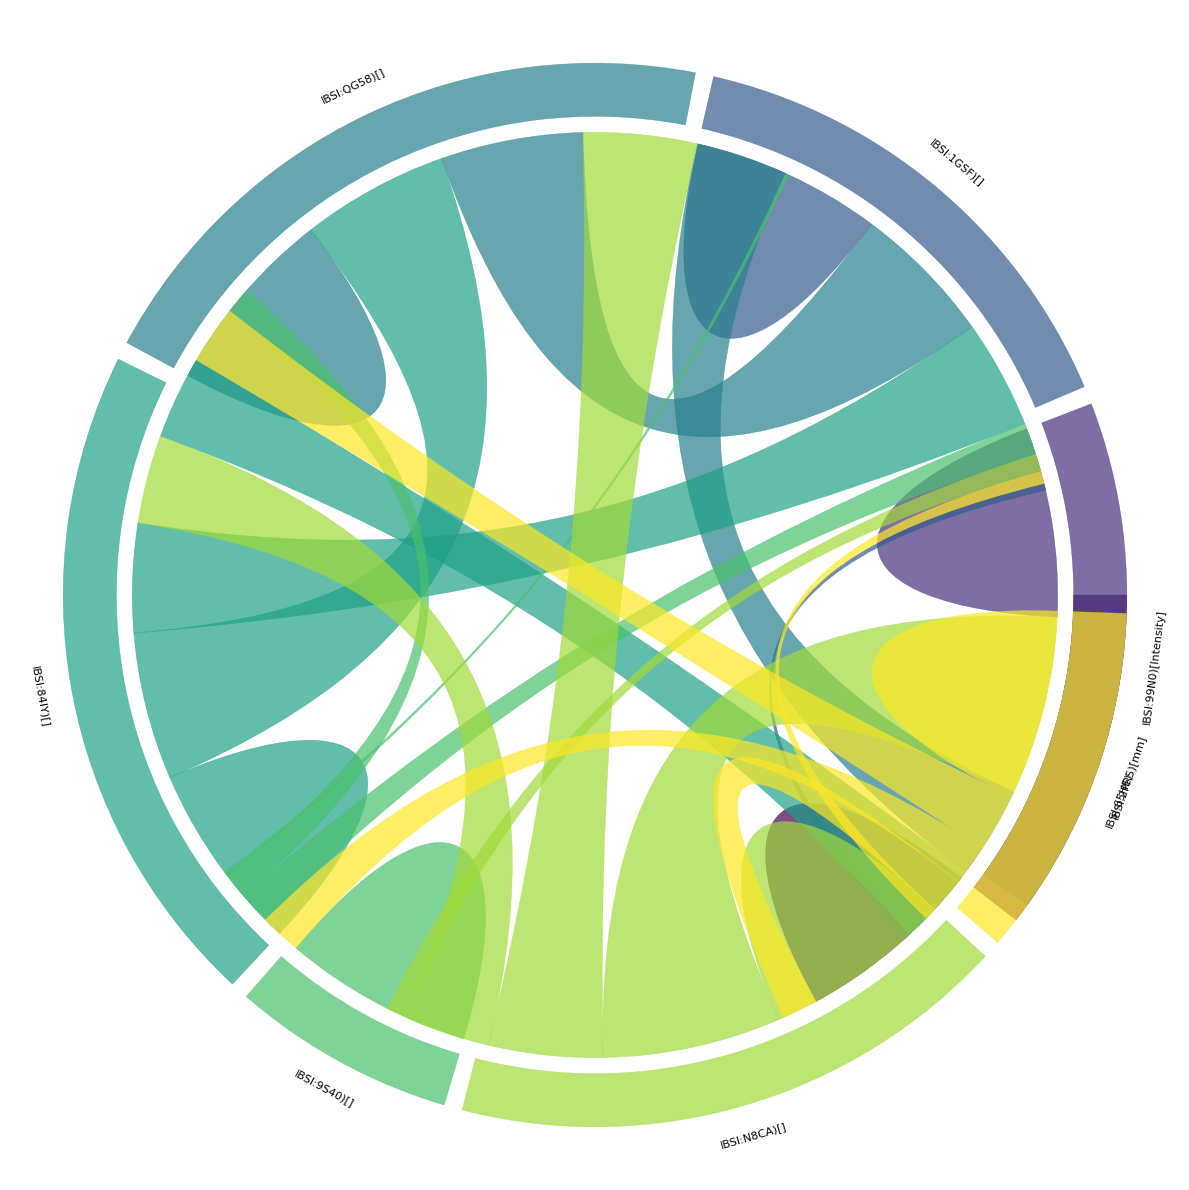

In [64]:
# Correlation between selected features
plot_chord_diagram(X_selected)

In [65]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_sorted)

In [66]:
# Evaluate the model perfonmance on 8 selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999978401015
Mean MAE: 6.163716491193501e-05
Mean MSE: 5.324514372689353e-09
Mean RMSE: 7.296927005726008e-05


Mean Test Scores:
Mean R2 Score: 0.8259065861913703
Mean MAE: 0.15153159794951465
Mean MSE: 0.09834115076328298
Mean RMSE: 0.3135939265408102



Section 3: Three-Step Feature Selection using Lasso Regression (Starting from 50% feature removal), Random Forest and Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [69]:
# Step1: Remove 50% of features using lasso
lasso = Lasso(alpha=0.05, max_iter=10000) 
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]

feature_coefficients = pd.Series(lasso.coef_, index=X.columns)
sorted_coeffs = feature_coefficients.abs().sort_values(ascending=False)
num_features_to_keep = len(X.columns) // 2
selected_features = sorted_coeffs[:num_features_to_keep].index

for f, feature in enumerate(selected_features):
    print("%d. Feature %s (%f)" % (f + 1, feature, lasso.coef_[f]))

1. Feature LOC (-0.810259)
2. Feature GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO) (-0.000000)
3. Feature GLCM_Correlation(IBSI:NI2N) (-0.000000)
4. Feature GLSZM_ZonePercentage(IBSI:P30P) (-0.000000)
5. Feature GLCM_Contrast(IBSI:ACUI) (-0.000000)
6. Feature INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity] (-0.000000)
7. Feature MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[] (-0.208166)
8. Feature NGTDM_Coarseness(IBSI:QCDE) (-0.000000)
9. Feature INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[] (-0.237499)
10. Feature MORPHOLOGICAL_Compacity(IBSI:No)[] (-0.000000)
11. Feature NGTDM_Busyness(IBSI:NQ30) (-0.000000)
12. Feature INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity] (-0.000000)
13. Feature INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[] (-0.006750)
14. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm] (-0.000000)
15. Feature GLCM_ClusterShade(IBSI:7NFM) (-0.000000)
16. Feature GLCM_ClusterProminence(IBSI:AE86) (

In [70]:
eli5.show_weights(lasso, top=-1, feature_names = X.columns.tolist())

Weight?,Feature
+1.432,<BIAS>
+0.601,GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)
+0.320,GLCM_Contrast(IBSI:ACUI)
+0.067,NGTDM_Busyness(IBSI:NQ30)
-0.005,GLCM_ClusterShade(IBSI:7NFM)
-0.007,MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]
-0.034,INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[]
-0.053,INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]
-0.208,MORPHOLOGICAL_Compacity(IBSI:No)[]
-0.211,INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]


In [71]:
X_selected = X[selected_features]

In [72]:
# Step 1 selected features
X_selected.columns

Index(['LOC', 'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLCM_Correlation(IBSI:NI2N)', 'GLSZM_ZonePercentage(IBSI:P30P)',
       'GLCM_Contrast(IBSI:ACUI)',
       'INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'NGTDM_Coarseness(IBSI:QCDE)',
       'INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]',
       'MORPHOLOGICAL_Compacity(IBSI:No)[]', 'NGTDM_Busyness(IBSI:NQ30)',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'GLCM_ClusterShade(IBSI:7NFM)', 'GLCM_ClusterProminence(IBSI:AE86)',
       'GLCM_Autocorrelation(IBSI:QWB0)',
       'INTENSITY-HISTOGRAM_Uniformity(IBSI:BJ5W)[Intensity]',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradient(IBSI:12CE)[Intensity]',
       'GLCM_NormalisedInverseDifferenceMoment(IBS

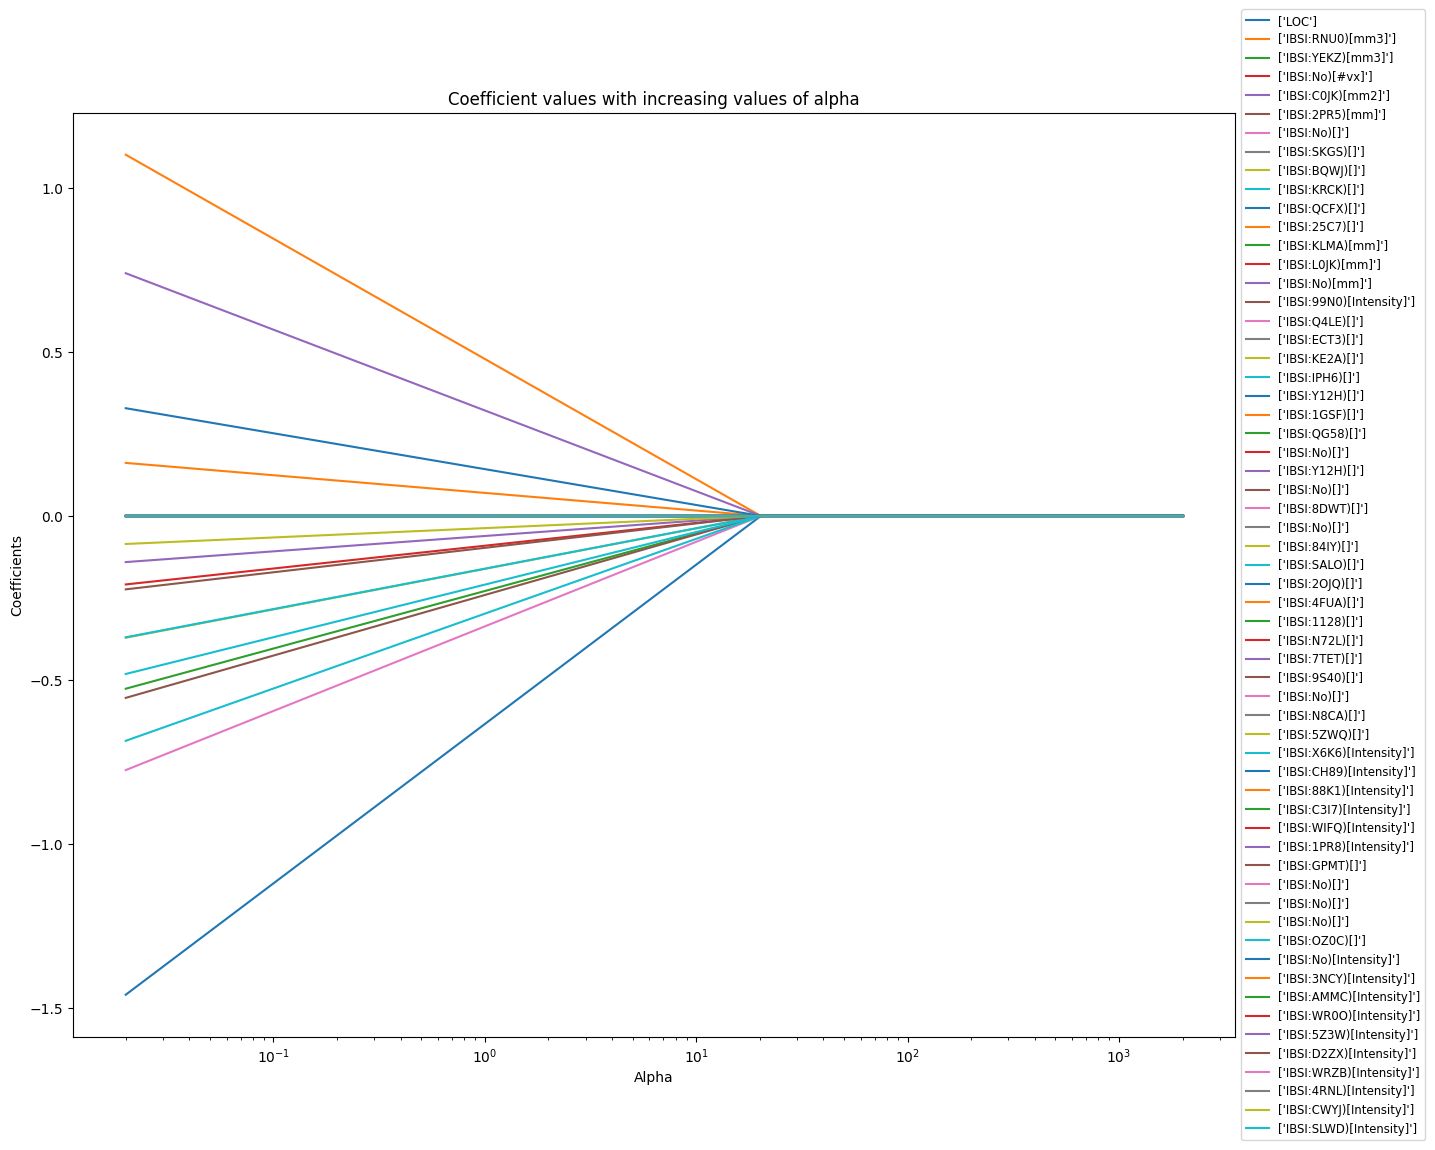

In [73]:
plt.figure(figsize=(15, 12))  

alphas = np.linspace(0.01, 1000, 100)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(StandardScaler().fit_transform(X_selected), y)
    coefs.append(lasso.coef_)

ax = plt.gca()
for idx, feature_coef in enumerate(np.array(coefs).T):
    ax.plot(alphas*2, feature_coef, label=get_simple_feature_name([X.columns[idx]]))

ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
ax.grid(False)
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title("Coefficient values with increasing values of alpha")
plt.show()

In [74]:
# Encode the LOC feature using one hot encoding
X_selected_encoded = one_hot_encoding(X_selected, 'LOC')

In [75]:
X_selected_encoded.columns

Index(['GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLCM_Correlation(IBSI:NI2N)', 'GLSZM_ZonePercentage(IBSI:P30P)',
       'GLCM_Contrast(IBSI:ACUI)',
       'INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'NGTDM_Coarseness(IBSI:QCDE)',
       'INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]',
       'MORPHOLOGICAL_Compacity(IBSI:No)[]', 'NGTDM_Busyness(IBSI:NQ30)',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogram25thPercentile(IBSI:No)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'GLCM_ClusterShade(IBSI:7NFM)', 'GLCM_ClusterProminence(IBSI:AE86)',
       'GLCM_Autocorrelation(IBSI:QWB0)',
       'INTENSITY-HISTOGRAM_Uniformity(IBSI:BJ5W)[Intensity]',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradient(IBSI:12CE)[Intensity]',
       'GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO)

In [76]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_encoded)

In [77]:
# Evaluate the model perfonmance on lasso selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999985837285
Mean MAE: 4.708252079001264e-05
Mean MSE: 3.4202691256012424e-09
Mean RMSE: 5.84830669989292e-05


Mean Test Scores:
Mean R2 Score: 0.832886427195733
Mean MAE: 0.2000119118624425
Mean MSE: 0.1315622352195567
Mean RMSE: 0.3627150882160222



Text(0.5, 1.0, 'Feature Importance ')

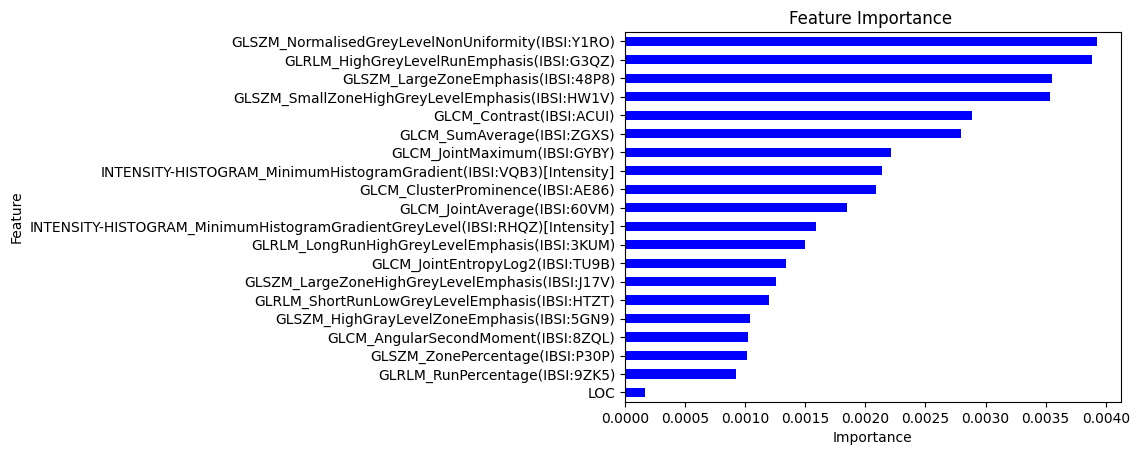

In [78]:
# Step 2: Train a Random Forest regressor with 100 decision trees 
# Select features from step 1 with rf feature importance > 0.02
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_selected, y)

importances_df = pd.Series(rf.feature_importances_, index=X_selected.columns)
importances_df.sort_values(ascending=True, inplace=True)
importances_df[:20].plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance ")

In [79]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_selected.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_selected.columns.values[indices[f]], 
          importances[indices[f]]))

1. Feature GLCM_Correlation(IBSI:NI2N) (0.183478)
2. Feature NGTDM_Contrast(IBSI:65HE) (0.135592)
3. Feature INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity] (0.076842)
4. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3) (0.047866)
5. Feature GLRLM_RunLengthNonUniformity(IBSI:W92Y) (0.044435)
6. Feature INTENSITY-HISTOGRAM_MaximumHistogramGradient(IBSI:12CE)[Intensity] (0.035437)
7. Feature INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity] (0.033321)
8. Feature NGTDM_Coarseness(IBSI:QCDE) (0.027323)
9. Feature GLSZM_GreyLevelNonUniformity(IBSI:JNSA) (0.025796)
10. Feature GLSZM_ZoneSizeEntropy(IBSI:GU8N) (0.023595)
11. Feature INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity] (0.021725)
12. Feature GLCM_DifferenceVariance(IBSI:D3YU) (0.021684)
13. Feature GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO) (0.019192)
14. Feature GLSZM_SmallZoneEmphasis(IBSI:5QRC) (0.018005)
15. Feature INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[] (0.01

In [80]:
X_selected2 = X_selected.iloc[:, importances>0.02]

In [81]:
# Step 2 selected features
X_selected2.columns

Index(['GLCM_Correlation(IBSI:NI2N)',
       'INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]',
       'NGTDM_Coarseness(IBSI:QCDE)',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradient(IBSI:12CE)[Intensity]',
       'GLCM_DifferenceVariance(IBSI:D3YU)',
       'GLSZM_ZoneSizeEntropy(IBSI:GU8N)',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLSZM_GreyLevelNonUniformity(IBSI:JNSA)',
       'INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]',
       'NGTDM_Contrast(IBSI:65HE)', 'GLRLM_RunLengthNonUniformity(IBSI:W92Y)'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


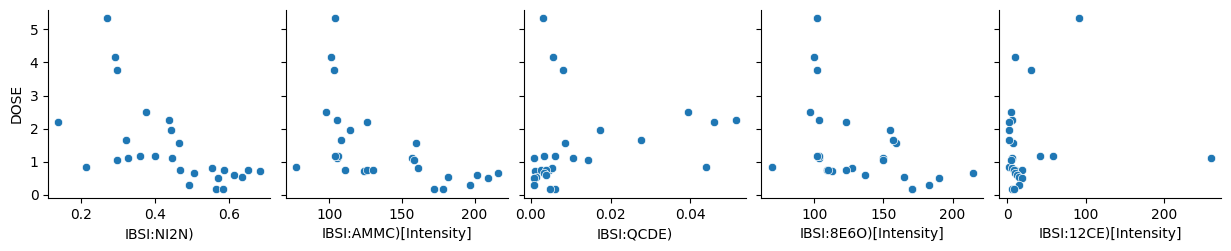

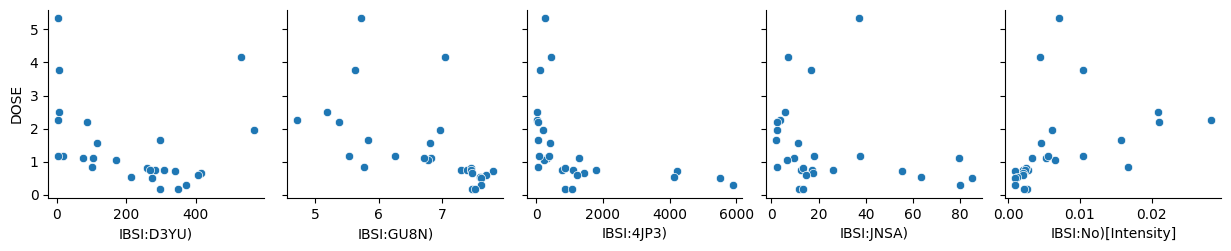

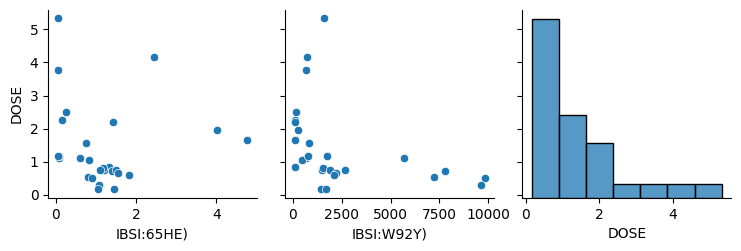

In [82]:
pair_plot(X_selected2, y)

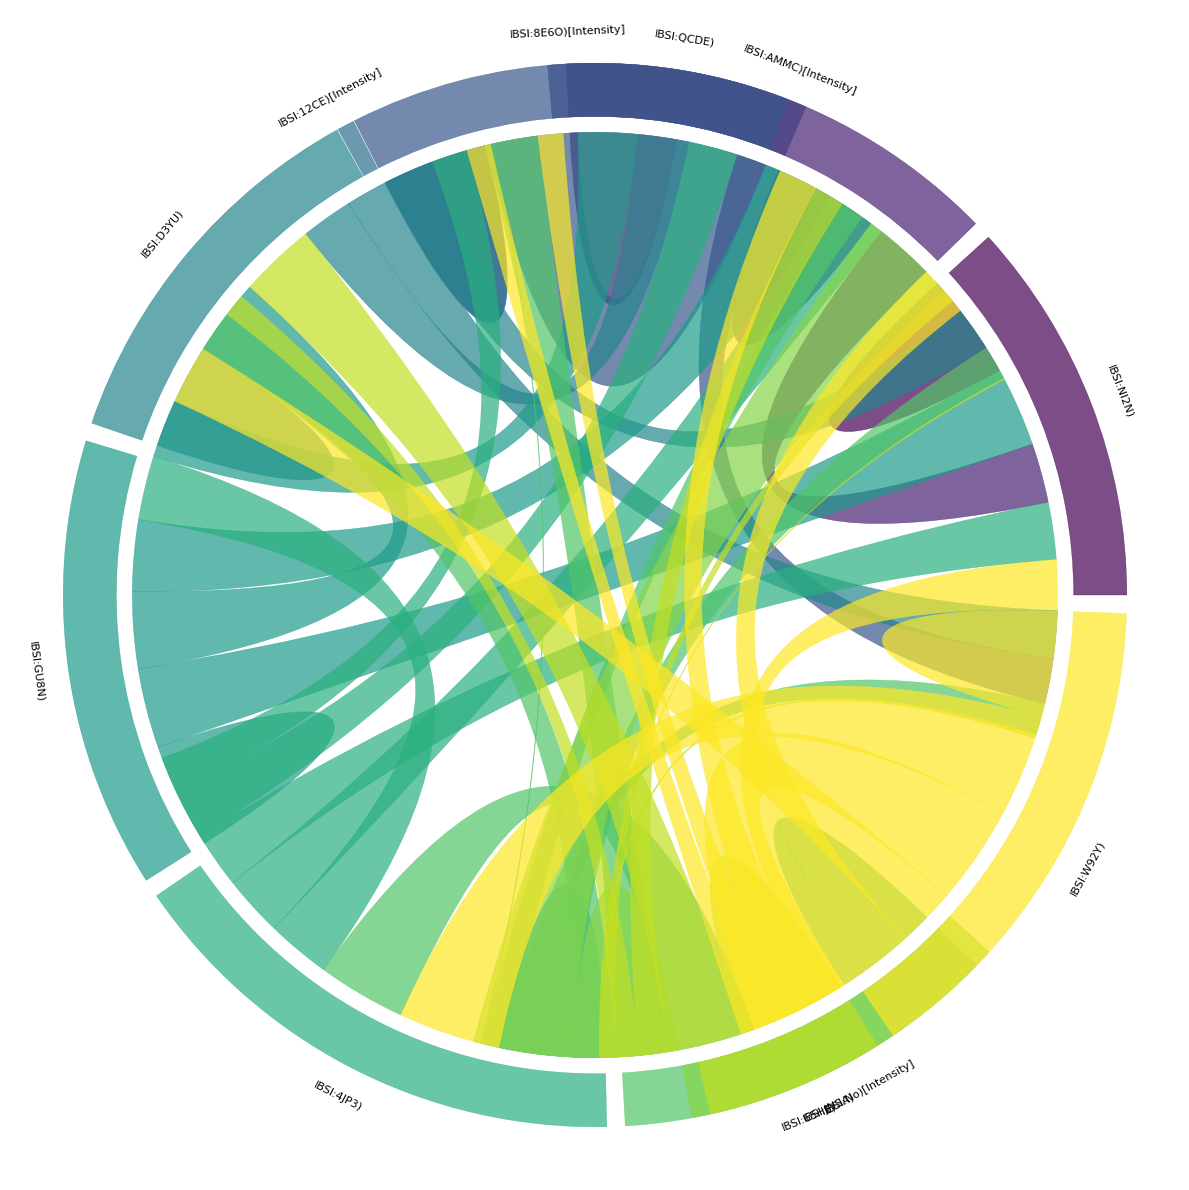

In [83]:
plot_chord_diagram(X_selected2)

In [84]:
X_selected2_encoded = one_hot_encoding(X_selected2, 'LOC')

In [85]:
# Evaluate model perfonmace on random forest selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected2_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999981974084
Mean MAE: 5.204600895156793e-05
Mean MSE: 4.446126153014803e-09
Mean RMSE: 6.667927828804692e-05


Mean Test Scores:
Mean R2 Score: 0.9200724773805967
Mean MAE: 0.16371532302706823
Mean MSE: 0.0818992794951989
Mean RMSE: 0.286180501598552



In [86]:
# Step 3: Recursive Feature Elimination (RFE) Using XGBRegressor as the estimator
# Select 8 top features from step 2 selected features
estimator = XGBRegressor()
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_selected2, y)  
selected_features = X_selected2.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))


1. Feature GLCM_Correlation(IBSI:NI2N)
2. Feature INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]
3. Feature NGTDM_Coarseness(IBSI:QCDE)
4. Feature INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]
5. Feature GLCM_DifferenceVariance(IBSI:D3YU)
6. Feature GLSZM_ZoneSizeEntropy(IBSI:GU8N)
7. Feature NGTDM_Contrast(IBSI:65HE)
8. Feature GLRLM_RunLengthNonUniformity(IBSI:W92Y)


In [87]:
X_selected3 = X_selected2[selected_features]

In [88]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected3_sorted = X_selected2.iloc[:, sorted_selected_indices]

In [89]:
X_selected3_sorted.shape

(27, 8)

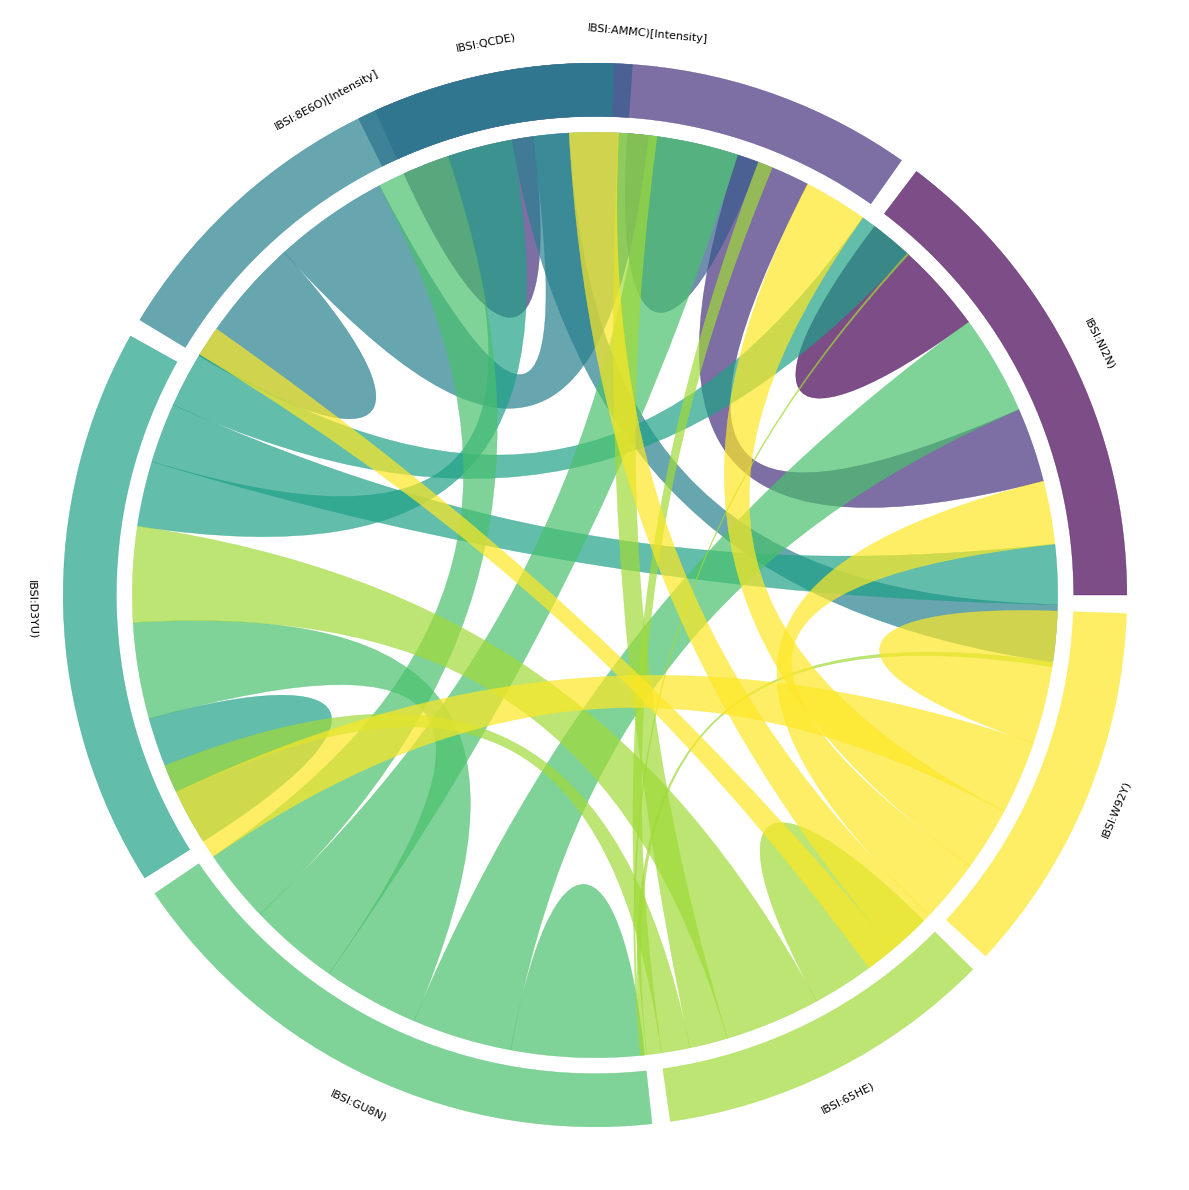

In [90]:
# Correlation plot of final selected features
plot_chord_diagram(X_selected3)

In [91]:
# Final 8 seleted features
X_selected3.columns

Index(['GLCM_Correlation(IBSI:NI2N)',
       'INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]',
       'NGTDM_Coarseness(IBSI:QCDE)',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradientGreyLevel(IBSI:8E6O)[Intensity]',
       'GLCM_DifferenceVariance(IBSI:D3YU)',
       'GLSZM_ZoneSizeEntropy(IBSI:GU8N)', 'NGTDM_Contrast(IBSI:65HE)',
       'GLRLM_RunLengthNonUniformity(IBSI:W92Y)'],
      dtype='object')

In [92]:
X_selected3_encoded = one_hot_encoding(X_selected3_sorted, 'LOC')

In [93]:
X_selected3_scaled = StandardScaler().fit_transform(X_selected3_encoded)

In [94]:
# Evaluation on 8 final selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999955918729
Mean MAE: 8.22464198574274e-05
Mean MSE: 1.0702768108839754e-08
Mean RMSE: 0.00010345418362173541


Mean Test Scores:
Mean R2 Score: 0.795520634042551
Mean MAE: 0.19155894122812883
Mean MSE: 0.09537424095459217
Mean RMSE: 0.3088272024200462

